In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from scipy.integrate import odeint
import py_analyze_tools.tools as pat
import numpy as np
from pprint import pprint

In [2]:
traj = pat.Trajectory("../generate/simple_trajectory_.h5")
traj.counts = traj.counts[:45*500]
traj.add_fusion(0, 1, 2)
traj.add_fission(2, 0, 1)
traj.add_conversion(0, 1)
traj.add_conversion(0, 3)
traj.add_conversion(3, 0)
xi = traj.estimate(.003)

max counts = 6000.0, min nonzero counts = 1.0


In [6]:
cv = pat.CV(traj)
result = cv.calculate_cost([0], range(0, 6000), range(6000, traj.n_time_steps))
norm_of_coeff = np.linalg.norm(result.coefficients[0], ord=1)
print("norm of coefficients for alpha=0: {}".format(norm_of_coeff))
quotient = cv._scale*result.costs_test[0]*result.costs_test[0]/norm_of_coeff
print("quotient = {}, order of magnitude = {}".format(quotient, pat.magnitude(quotient)))

norm of coefficients for alpha=0: 0.012111227035930386
quotient = 9878.557217995249, order of magnitude = 3


In [7]:
search_grid = np.linspace(0, 10**(pat.magnitude(quotient)+1), num=100)

In [8]:
cv_result = cv.calculate_cost(search_grid, range(0, 6000), range(6000, traj.n_time_steps))
min_idx = np.argmin(cv_result.costs_test)
print("best suited alpha found at idx={}, alpha={}, costs_test={}".format(min_idx, cv_result.alphas[min_idx], cv_result.costs_test[min_idx]))

best suited alpha found at idx=2, alpha=202.02020202020202, costs_test=4583.1852948963315


# more complicated problem

In [2]:
traj = pat.Trajectory("../generate/simple_trajectory_2.h5")
traj.counts = traj.counts
traj.add_fusion(0, 1, 2)  # A + B -> C
traj.add_fusion(0, 2, 3)  # A + C -> D
traj.add_fusion(0, 3, 2)  # A + D -> C
traj.add_fusion(1, 2, 3)  # B + C -> D
traj.add_fission(2, 0, 1) # C -> A + B
traj.add_fission(0, 1, 2) # A -> B + C
traj.add_conversion(0, 1) # A -> B
traj.add_conversion(0, 3) # A -> D
traj.add_conversion(3, 0) # D -> A
traj.add_conversion(0, 2) # A -> C
traj.add_conversion(1, 2) # B -> C
traj.add_conversion(2, 3) # C -> D

In [3]:
cv = pat.CV(traj)
alpha = cv.find_alpha_recurse(n_grid_points=10)
print("found alpha=%s" % alpha)

max counts = 6000.0, min nonzero counts = 1.0
norm of coefficients for alpha=0: 0.6350672467542671
quotient = 3531.6037607509197, order of magnitude = 3
best suited alpha found on level 0 at idx=1, alpha=1111.111111111111, costs_test=5914.111548862873
best suited alpha found on level 1 at idx=0, alpha=555.5555555555555, costs_test=5808.897698126237
best suited alpha found on level 2 at idx=1, alpha=507.5445816186557, costs_test=5803.2861895190235
best suited alpha found on level 3 at idx=2, alpha=503.7341868617589, costs_test=5801.985552654981
best suited alpha found on level 4 at idx=7, alpha=504.15756405696965, costs_test=5802.02515545474
found alpha=504.157564057


In [4]:
xi = traj.estimate(0)

In [5]:
xi_alpha = traj.estimate(alpha)

In [6]:
print("estimated coefficients: %s" % xi)
_=traj.rate_info(xi[0])

estimated coefficients: [  1.66412499e-06   2.65919058e-07   0.00000000e+00   2.34620618e-08
   4.26754210e-04   9.62436746e-05   1.68483473e-03   9.20671754e-03
   9.77887437e-03   1.07274322e-04   1.92933219e-03   0.00000000e+00]
erban chapman rate (per volume): 0.06848398371542153
lasso fitted rate (per counts): 1.664124990440515e-06
lasso fitted rate (per volume): 0.005616421842736738


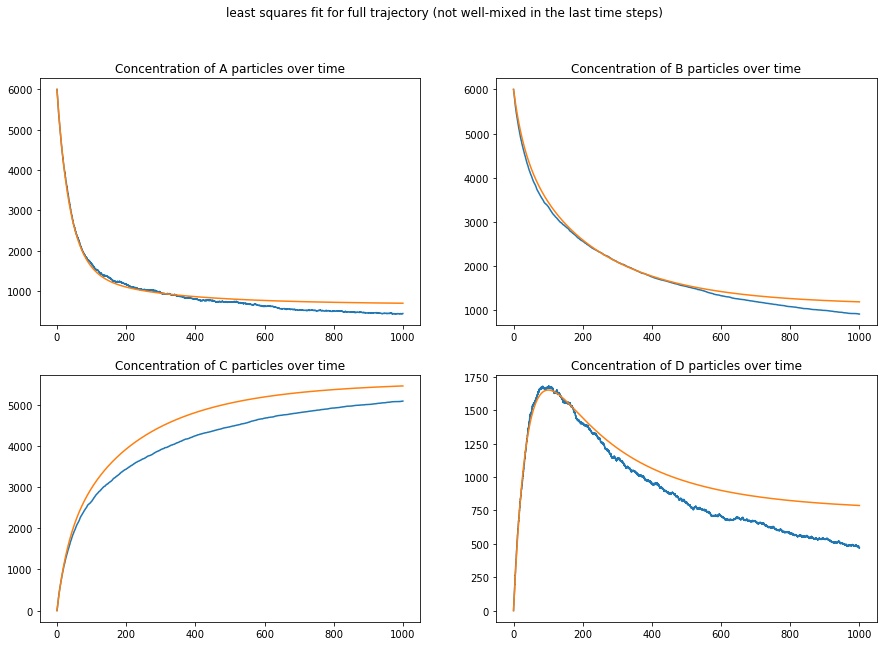

In [7]:
def fun(data, _):
    theta = np.array([f(data) for f in traj.thetas])
    return np.matmul(xi, theta)
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
f.suptitle("least squares fit for full trajectory (not well-mixed in the last time steps)")
num_solution = odeint(fun, traj.counts[0], np.arange(0, traj.n_time_steps*.01, .01))
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]
for i in range(traj.n_species):
    axes[i].plot(np.arange(0, traj.n_time_steps*.01, .01), traj.counts[:,i])
    axes[i].plot(np.arange(0, traj.n_time_steps*.01, .01), num_solution[:, i])
    axes[i].set_title("Concentration of %s particles over time" % labels[i])
plt.show()

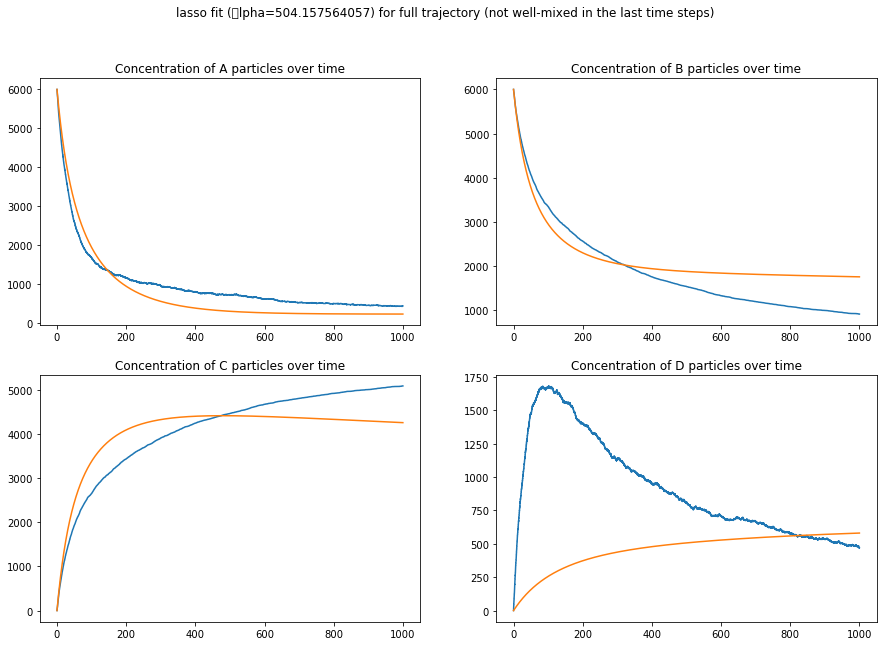

In [8]:
def fun(data, _):
    theta = np.array([f(data) for f in traj.thetas])
    return np.matmul(xi_alpha, theta)
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
f.suptitle("lasso fit (\alpha=%s) for full trajectory (not well-mixed in the last time steps)"%alpha)
num_solution = odeint(fun, traj.counts[0], np.arange(0, traj.n_time_steps*.01, .01))
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]
for i in range(traj.n_species):
    axes[i].plot(np.arange(0, traj.n_time_steps*.01, .01), traj.counts[:,i])
    axes[i].plot(np.arange(0, traj.n_time_steps*.01, .01), num_solution[:, i])
    axes[i].set_title("Concentration of %s particles over time" % labels[i])
plt.show()

In [24]:
traj = pat.Trajectory("../generate/simple_trajectory_2.h5")
traj.counts = traj.counts[:60*500]
traj.add_fusion(0, 1, 2)  # A + B -> C
traj.add_fusion(0, 2, 3)  # A + C -> D
traj.add_fusion(0, 3, 2)  # A + D -> C
traj.add_fusion(1, 2, 3)  # B + C -> D
traj.add_fission(2, 0, 1) # C -> A + B
traj.add_fission(0, 1, 2) # A -> B + C
traj.add_conversion(0, 1) # A -> B
traj.add_conversion(0, 3) # A -> D
traj.add_conversion(3, 0) # D -> A
traj.add_conversion(0, 2) # A -> C
traj.add_conversion(1, 2) # B -> C
traj.add_conversion(2, 3) # C -> D
traj.update()

cv = pat.CV(traj)
alpha = cv.find_alpha(n_grid_points=5, train_indices=range(0, traj.n_time_steps//4), test_indices=range(traj.n_time_steps//4, 2*traj.n_time_steps//4))
print("found alpha=%s" % alpha)
xi = traj.estimate(0)

max counts = 6000.0, min nonzero counts = 1.0
norm of coefficients for alpha=0: 0.017776746644807575
quotient = 0.1412552862458288, order of magnitude = -1
best suited alpha found at idx=0, alpha=0.0, costs_test=0.002511059435831871
found alpha=0.0


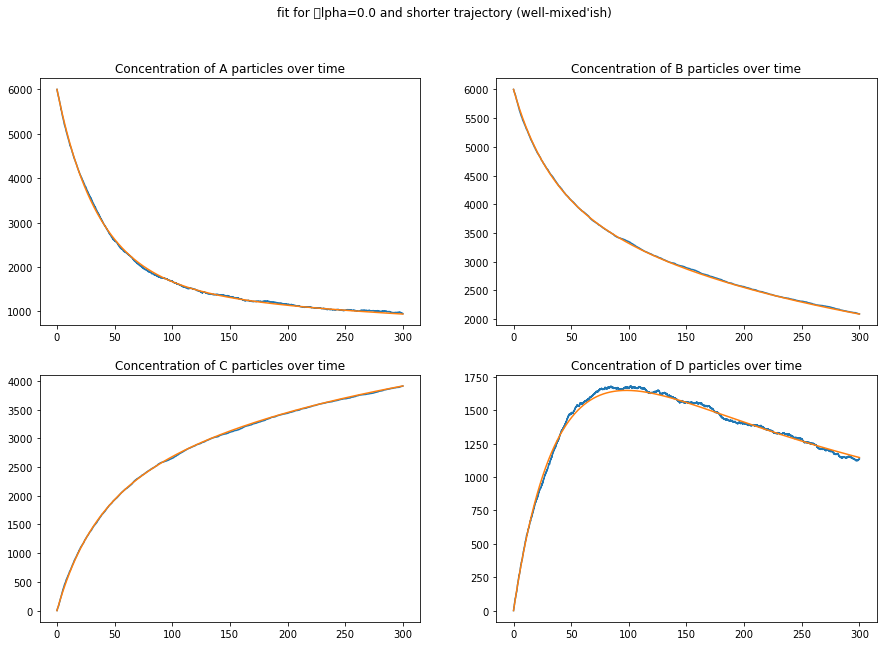

In [25]:
def fun(data, _):
    theta = np.array([f(data) for f in traj.thetas])
    return np.matmul(xi, theta)
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
f.suptitle("fit for \alpha=%s and shorter trajectory (well-mixed'ish)" % alpha)
num_solution = odeint(fun, traj.counts[0], np.arange(0, traj.n_time_steps*.01, .01))
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]
for i in range(traj.n_species):
    axes[i].plot(np.arange(0, traj.n_time_steps*.01, .01), traj.counts[:,i])
    axes[i].plot(np.arange(0, traj.n_time_steps*.01, .01), num_solution[:, i])
    axes[i].set_title("Concentration of %s particles over time" % labels[i])
plt.show()

# trajectory with fission C->A+B

In [2]:
traj = pat.Trajectory("../generate/simple_trajectory_3.h5")
traj.counts = traj.counts[:70*500]
traj.add_fusion(0, 1, 2)  # A + B -> C
traj.add_fusion(0, 2, 3)  # A + C -> D
traj.add_fusion(0, 3, 2)  # A + D -> C
traj.add_fusion(1, 2, 3)  # B + C -> D
traj.add_fission(2, 0, 1) # C -> A + B
traj.add_fission(0, 1, 2) # A -> B + C
traj.add_conversion(0, 1) # A -> B
traj.add_conversion(0, 3) # A -> D
traj.add_conversion(3, 0) # D -> A
traj.add_conversion(0, 2) # A -> C
traj.add_conversion(1, 2) # B -> C
traj.add_conversion(2, 3) # C -> D
traj.update()

max counts = 6000.0, min nonzero counts = 1.0


In [4]:
cv = pat.CV(traj)
alpha, cv_result = cv.find_alpha(return_cv_result=True, n_grid_points=6432, train_indices=range(0, traj.n_time_steps//3), test_indices=range(traj.n_time_steps//3, traj.n_time_steps))
print("found alpha=%s" % alpha)

norm of coefficients for alpha=0: 0.09544048025450633
quotient = 0.11982037052751457, order of magnitude = -1


Process ForkPoolWorker-19:
Process ForkPoolWorker-22:
Process ForkPoolWorker-17:
Process ForkPoolWorker-24:
Traceback (most recent call last):
Process ForkPoolWorker-20:
  File "/home/mho/miniconda2/envs/readdy_dev/lib/python3.6/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-21:
  File "/home/mho/miniconda2/envs/readdy_dev/lib/python3.6/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
Process ForkPoolWorker-18:
  File "/home/mho/miniconda2/envs/readdy_dev/lib/python3.6/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
  File "/home/mho/miniconda2/envs/readdy_dev/lib/python3.6/site-packages/multiprocess/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/mho/miniconda2/envs/readdy_dev/lib/python3.6/si

  File "/home/mho/Development/readdy/readdy_learn/analyze_tools/py_analyze_tools/tools.py", line 375, in <lambda>
    self._traj.n_species, cv.large_theta_train, cv.train_data_derivative),
  File "/home/mho/miniconda2/envs/readdy_dev/lib/python3.6/site-packages/scipy/optimize/_minimize.py", line 450, in minimize
    callback=callback, **options)
  File "/home/mho/Development/readdy/readdy_learn/analyze_tools/py_analyze_tools/tools.py", line 75, in frobenius_l1_regression
    method='L-BFGS-B')
  File "/home/mho/miniconda2/envs/readdy_dev/lib/python3.6/site-packages/scipy/optimize/_minimize.py", line 450, in minimize
    callback=callback, **options)
  File "/home/mho/miniconda2/envs/readdy_dev/lib/python3.6/site-packages/scipy/optimize/lbfgsb.py", line 328, in _minimize_lbfgsb
    f, g = func_and_grad(x)
  File "/home/mho/miniconda2/envs/readdy_dev/lib/python3.6/site-packages/scipy/optimize/lbfgsb.py", line 274, in func_and_grad
    g = _approx_fprime_helper(x, fun, epsilon, args=args,

KeyboardInterrupt
  File "/home/mho/Development/readdy/readdy_learn/analyze_tools/py_analyze_tools/tools.py", line 70, in <lambda>
    lambda x: at.lasso_minimizer_objective_fun(x, alpha, scale * theta, scale * dcounts_dt),
KeyboardInterrupt


KeyboardInterrupt: 

In [38]:
xi = traj.estimate(alpha)

In [39]:
print(xi)

[  1.96008738e-06   9.94587054e-03   1.00520362e-02   9.84303477e-03]


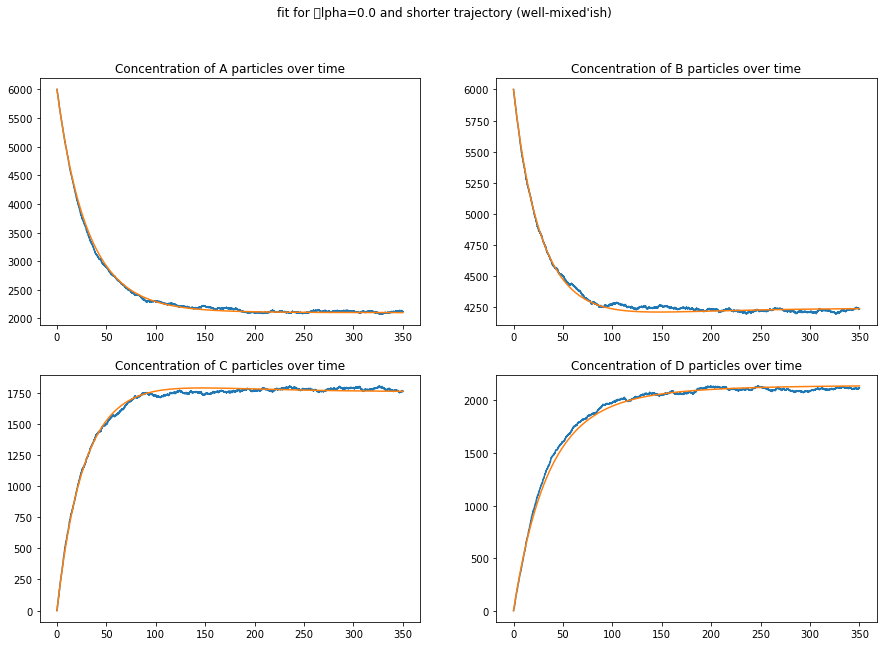

In [40]:
def fun(data, _):
    theta = np.array([f(data) for f in traj.thetas])
    return np.matmul(xi, theta)
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
f.suptitle("fit for \alpha=%s and shorter trajectory (well-mixed'ish)" % alpha)
num_solution = odeint(fun, traj.counts[0], np.arange(0, traj.n_time_steps*.01, .01))
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]
for i in range(traj.n_species):
    axes[i].plot(np.arange(0, traj.n_time_steps*.01, .01), traj.counts[:,i])
    axes[i].plot(np.arange(0, traj.n_time_steps*.01, .01), num_solution[:, i])
    axes[i].set_title("Concentration of %s particles over time" % labels[i])
plt.show()